# kNN-VC and LinearVC experiments using parallel data

Herman Kamper, 2024

In [1]:
from concurrent.futures import ProcessPoolExecutor
from datetime import datetime
from numpy import linalg
from pathlib import Path
from tqdm.notebook import tqdm
import celer
import IPython.display as display
import numpy as np
import scipy
import sys
import torch
import torchaudio

from reduced_rank_ridge import ReducedRankRidge
from utils import fast_cosine_dist

In [2]:
device = "cuda"

## Models

In [3]:
wavlm = torch.hub.load("bshall/knn-vc", "wavlm_large", trust_repo=True, device=device)

Using cache found in /home/kamperh/.cache/torch/hub/bshall_knn-vc_master
/home/kamperh/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


WavLM-Large loaded with 315,453,120 parameters.


In [4]:
hifigan, _ = torch.hub.load("bshall/knn-vc", "hifigan_wavlm", trust_repo=True, device=device, prematched=True)

Using cache found in /home/kamperh/.cache/torch/hub/bshall_knn-vc_master


Removing weight norm...
[HiFiGAN] Generator loaded with 16,523,393 parameters.


## LinearVC using parallel utterances (single)

In [5]:
subset = "scottish"
wav_dir = Path(f"/home/kamperh/scratch/vctk/wav/{subset}/")
k_top = 1

In [69]:
# Projection matrices

# source = "p225"  # Southern English
# target = "p226"  # Surrey
# target = "p232"  # Southern English
# target = "p228"  # Southern English
# target = "p234"  # Scottish
# target = "p323"  # South African
# target = "p347"  # South African
# target = "p376"  # Indian

# source = "p234"
# target = "p237"

# source = "p234"
# target = "p241"

# source = "p237"
# target = "p241"

source = "p247"
target = "p249"

utt = "008"  # 002, 008, 023
source_wav_fn = wav_dir / source / f"{source}_{utt}.wav"
target_wav_fn = wav_dir / target / f"{target}_{utt}.wav"

# Features
source_wav, _ = torchaudio.load(source_wav_fn)
source_wav = source_wav.to(device)
target_wav, _ = torchaudio.load(target_wav_fn)
target_wav = target_wav.to(device)
with torch.inference_mode():
    source_feats, _ = wavlm.extract_features(source_wav, output_layer=6)
    target_feats, _ = wavlm.extract_features(target_wav, output_layer=6)
source_feats = source_feats.squeeze()
target_feats = target_feats.squeeze()
# print("source_feats shape", source_feats.shape)
# print("target_feats shape", target_feats.shape)\

# Matching
dists = fast_cosine_dist(source_feats, target_feats, device=device)
best = dists.topk(k=k_top, largest=False, dim=-1)        
linear_target = target_feats[best.indices].mean(dim=1)

# Lasso regression
linear = celer.Lasso(alpha=20.0, fit_intercept=False).fit(
    source_feats.squeeze().cpu(), linear_target.cpu()
)
W = linear.coef_.T

# Orthogonal
# W, _ = scipy.linalg.orthogonal_procrustes(source_feats.cpu(), linear_target.cpu())

# # Regularised ridge regression
# rank = 100
# linear = ReducedRankRidge(alpha=1.0, fit_intercept=False, rank=rank).fit(
#     source_feats.squeeze().cpu(), linear_target.cpu(),
# )
# W = linear.Vr @ linear.Vrt_times_beta
# W = W.T

# # Additive transform
# delta = torch.mean(
#     linear_target.cpu(), axis=0) - torch.mean(source_feats.squeeze().cpu(), axis=0
#  )
# delta = delta.to(device)

# Matrix properties
tol = 1e-4
print("Matrix rank:", linalg.matrix_rank(W, tol=tol))
print(
    "No. parameters for low rank: {:,d}".format(
        linalg.matrix_rank(W, tol=tol) * W.shape[0] * 2
    )
)
print(
    "Proportion zero: {:.2f}%".format(
        len(np.where(np.abs(W) < tol)[0]) / W.shape[0] ** 2 * 100
    )
)
print(
    "No. non-zero elements: {:,d} out of {:,d}".format(
        len(np.where(np.abs(W) > tol)[0]),
        W.shape[0] * W.shape[1]
    )
)

W = torch.from_numpy(W).float().to(device)

Matrix rank: 33
No. parameters for low rank: 67,584
Proportion zero: 99.92%
No. non-zero elements: 819 out of 1,048,576


In [70]:
display.Audio(source_wav.squeeze().cpu(), rate=16000)

In [71]:
display.Audio(target_wav.squeeze().cpu(), rate=16000)

In [72]:
wav_fn = wav_dir / source / f"{source}_057.wav"
# wav_fn = wav_dir / source / f"{source}_051.wav"
wav, _ = torchaudio.load(wav_fn)
wav = wav.to(device)
# wav = F.vad(wav, 16000)
display.Audio(wav.squeeze().cpu(), rate=16000)

In [73]:
with torch.inference_mode():
    feats, _ = wavlm.extract_features(
        wav, output_layer=6
    )

source_to_target_feats = feats @ W
# source_to_target_feats = feats + delta  # additive

with torch.inference_mode():
    wav_hat = hifigan(source_to_target_feats).squeeze(0)

In [74]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)

In [75]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)

(300.0, 0.0)

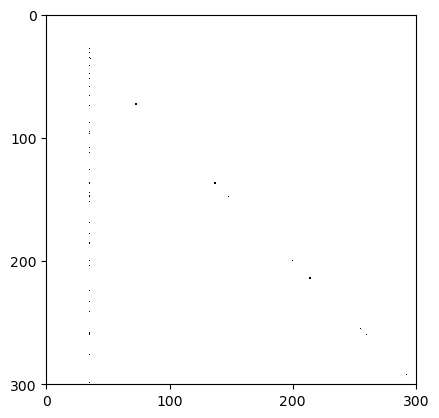

In [77]:
import matplotlib.pyplot as plt
W_numpy = W.cpu().numpy()
np.save(f"doc/{source}-{target}_{utt}.npy", W_numpy)
matrix = W_numpy.copy()
matrix[np.abs(matrix) < 1e-4] = 0.0
matrix[np.abs(matrix) > 1e-4] = 1.0
fig, ax = plt.subplots(1, 1)
ax.imshow(matrix.T, cmap="binary", aspect="equal", interpolation="none")

# ax.set_title(r"$\mathbf{W}^\top$")
ax.set_xticks([0, 100, 200, 300, 400, 500])
ax.set_yticks([0, 100, 200, 300, 400, 500])
ax.set_xlim([0, 300])
ax.set_ylim([300, 0])

## LinearVC using parallel utterances (dataset)

Only a single parallel utterance pair is used.

In [5]:
# exp_tag = "2024-09-16"
# subset = "english"
subset = "scottish"
# exp_tag = "2024-11-16"
exp_tag = "2024-11-17"
eval_csv = Path(f"data/speakersim_vctk_{subset}.csv")
wav_dir = Path(f"/home/kamperh/scratch/vctk/wav/{subset}/")
output_dir = Path(f"/home/kamperh/scratch/linearvc/vctk/{subset}/{exp_tag}")
speaker_fn = Path(f"data/vctk_{subset}.txt")

k_top = 1
# parallel_utt = "023"
parallel_utt = "008"

print("Reading:", speaker_fn)
with open(speaker_fn) as f:
    speakers = [line.strip() for line in f.readlines()]
print("No. speakers:", len(speakers))

output_dir.mkdir(parents=True, exist_ok=True)

Reading: data/vctk_scottish.txt
No. speakers: 19


### Parallel processing

In [38]:
# Matching

source_feats_list = []
target_feats_list = []
speaker_pairs_list = []

for source in tqdm(sorted(speakers)):
    for target in tqdm(sorted(speakers), leave=False):
        if source == target:
            continue

        source_wav_fn = wav_dir / source / f"{source}_{parallel_utt}.wav"
        target_wav_fn = wav_dir / target / f"{target}_{parallel_utt}.wav"
        source_wav, _ = torchaudio.load(source_wav_fn)
        source_wav = source_wav.to(device)
        target_wav, _ = torchaudio.load(target_wav_fn)
        target_wav = target_wav.to(device)
        with torch.inference_mode():
            source_feats, _ = wavlm.extract_features(source_wav, output_layer=6)
            target_feats, _ = wavlm.extract_features(target_wav, output_layer=6)
        source_feats = source_feats.squeeze()
        target_feats = target_feats.squeeze()

        # Matching without DTW
        dists = fast_cosine_dist(source_feats, target_feats, device=device)
        best = dists.topk(k=k_top, largest=False, dim=-1)        
        linear_target = target_feats[best.indices].mean(dim=1)

        # # Matching with DTW
        # source_feats_np = source_feats.cpu().numpy()
        # target_feats_np = target_feats.cpu().numpy()
        # s = np.ascontiguousarray(np.float64(source_feats_np))
        # t = np.ascontiguousarray(np.float64(target_feats_np))
        # path, _ = _dtw.multivariate_dtw(s, t, "cosine")
        # path.reverse()
        # source_path, target_path = zip(*path)
        # i_frame = 0
        # linear_target_idx = []
        # for i_source, i_target in path:
        #     if i_source == i_frame:
        #         linear_target_idx.append(i_target)
        #         i_frame += 1
        # linear_target = target_feats_np[linear_target_idx, :]
        # linear_target = torch.from_numpy(linear_target).float()
        
        # source_feats_list.append(np.float16(source_feats.squeeze().cpu().numpy()))
        # target_feats_list.append(np.float16(linear_target.cpu().numpy()))
        source_feats_list.append(source_feats.squeeze().cpu().numpy())
        target_feats_list.append(linear_target.cpu().numpy())
        speaker_pairs_list.append(f"{source}-{target}")

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
# Projection matrices

n_max_workers = 14


def get_projmat(source_feats, target_feats):
    # print(source_feats.shape)

    # # Unregularised
    # W, _, _, _ = linalg.lstsq(source_feats, target_feats)

    # # Orthogonal
    # W, _ = scipy.linalg.orthogonal_procrustes(source_feats, target_feats)
    
    # Lasso
    linear = celer.Lasso(alpha=0.4, fit_intercept=False).fit(
        source_feats, target_feats
    )
    W = linear.coef_.T

    return W


with ProcessPoolExecutor(max_workers=n_max_workers) as executor:
    results = list(
        tqdm(
            executor.map(get_projmat, source_feats_list, target_feats_list),
            total=len(speaker_pairs_list),
        )
    )

In [69]:
projmats = {}
for source_target, W in zip(speaker_pairs_list, results):

    W = torch.from_numpy(W).float().to(device)
    projmats[source_target] = W

### Serial processing

In [12]:
# Projection matrices
projmats = {}
for source in tqdm(sorted(speakers)):
    for target in tqdm(sorted(speakers), leave=False):
        if source == target:
            continue

        # Features
        source_wav_fn = wav_dir / source / f"{source}_{parallel_utt}.wav"
        target_wav_fn = wav_dir / target / f"{target}_{parallel_utt}.wav"
        source_wav, _ = torchaudio.load(source_wav_fn)
        source_wav = source_wav.to(device)
        target_wav, _ = torchaudio.load(target_wav_fn)
        target_wav = target_wav.to(device)
        with torch.inference_mode():
            source_feats, _ = wavlm.extract_features(source_wav, output_layer=6)
            target_feats, _ = wavlm.extract_features(target_wav, output_layer=6)
        source_feats = source_feats.squeeze()
        target_feats = target_feats.squeeze()

        # Matching without DTW
        dists = fast_cosine_dist(source_feats, target_feats, device=device)
        best = dists.topk(k=k_top, largest=False, dim=-1)        
        linear_target = target_feats[best.indices].mean(dim=1)

        # # Matching with DTW
        # source_feats_np = source_feats.cpu().numpy()
        # target_feats_np = target_feats.cpu().numpy()
        # s = np.ascontiguousarray(np.float64(source_feats_np))
        # t = np.ascontiguousarray(np.float64(target_feats_np))
        # path, _ = _dtw.multivariate_dtw(s, t, "cosine")
        # path.reverse()
        # source_path, target_path = zip(*path)
        # i_frame = 0
        # linear_target_idx = []
        # for i_source, i_target in path:
        #     if i_source == i_frame:
        #         linear_target_idx.append(i_target)
        #         i_frame += 1
        # linear_target = target_feats_np[linear_target_idx, :]
        # linear_target = torch.from_numpy(linear_target).float()

        # Unregularised
        # W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())

        # # Orthogonal
        # W, _ = scipy.linalg.orthogonal_procrustes(source_feats.cpu(), linear_target.cpu())

        # Ridge
        # linear = Ridge(alpha=5e3, fit_intercept=False).fit(
        #     source_feats.squeeze().cpu(), linear_target.cpu()
        # )
        # W = linear.coef_.T

        # Lasso
        linear = celer.Lasso(alpha=0.3, fit_intercept=False).fit(
            source_feats.squeeze().cpu(), linear_target.cpu()
        )
        W = linear.coef_.T        

        # # Regularised ridge
        # rank = 10
        # linear = ReducedRankRidge(alpha=1.0, fit_intercept=False, rank=rank).fit(
        #     source_feats.squeeze().cpu(), linear_target.cpu(),
        # )
        # W = linear.Vr @ linear.Vrt_times_beta
        # W = W.T

        # # Additive transform
        # delta = np.mean(linear_target.cpu().numpy(), axis=0) - np.mean(
        #     source_feats.squeeze().cpu().numpy(), axis=0
        # )
        # W = delta
        
        W = torch.from_numpy(W).float().to(device)
        projmats[f"{source}-{target}"] = W

    #     break
    # break

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [71]:
print("Writing:", output_dir / "projmats.pt")
torch.save(projmats, output_dir / "projmats.pt")

# # print("Reading:", output_dir / "projmats.pt")
# # projmats = torch.load(output_dir / "projmats.pt")

Writing: /home/kamperh/scratch/linearvc/vctk/scottish/2024-11-16/projmats.pt


In [17]:
output_dir.mkdir(parents=True, exist_ok=True)
print("Writing to:", output_dir)
with open(eval_csv) as f:
    for line in tqdm(f.readlines()):
        line = line.strip()
        if line[-1] == "0":
            (source, target, source_key, _, _) = line.split(",")

            source_wav_fn = (
                wav_dir / source / Path(source_key).stem
            ).with_suffix(".wav")
            source_wav, _ = torchaudio.load(source_wav_fn)
            source_wav = source_wav.to(device)
            with torch.inference_mode():
                source_feats, _ = wavlm.extract_features(
                    source_wav, output_layer=6
                )

            W_source_to_target = projmats[f"{source}-{target}"]

            source_to_target_feats = source_feats @ W_source_to_target
            # source_to_target_feats = source_feats + W_source_to_target  # additive

            with torch.inference_mode():
                wav_hat = hifigan(source_to_target_feats).squeeze(0)            

            cur_output_dir = Path(output_dir) / source_key.split("/")[0]
            cur_output_dir.mkdir(parents=True, exist_ok=True)
            output_fn = (cur_output_dir / source_key.split("/")[1]).with_suffix(
                ".wav"
            )
            torchaudio.save(output_fn, wav_hat.squeeze().cpu()[None], 16000)

            # print(source_wav_fn)
            # print(output_fn)
            # assert False

Writing to: /home/kamperh/scratch/linearvc/vctk/scottish/2024-11-17


  0%|          | 0/3421 [00:00<?, ?it/s]

In [18]:
class Arguments: pass
args = Arguments()
args.format = "vctk"
args.eval_csv = eval_csv
args.converted_dir = output_dir
args.groundtruth_dir = wav_dir

print("Run:")
print(
    f"./speaker_similarity.py --format {args.format}"
    f" {args.eval_csv} {args.converted_dir} {args.groundtruth_dir}"
)
print(
    f"./intelligibility.py --format {args.format} {args.converted_dir}"
    f" /home/kamperh/endgame/datasets/VCTK-Corpus/txt/"
)

# speaker_similarity(args)

Run:
./speaker_similarity.py --format vctk data/speakersim_vctk_scottish.csv /home/kamperh/scratch/linearvc/vctk/scottish/2024-11-17 /home/kamperh/scratch/vctk/wav/scottish
./intelligibility.py --format vctk /home/kamperh/scratch/linearvc/vctk/scottish/2024-11-17 /home/kamperh/endgame/datasets/VCTK-Corpus/txt/


Results, alpha=0.3, english:

               eer
    mean  0.314409
    std   0.083072

    WER: 7.58% +- 0.22%
    CER: 6.93% +- 0.12%

Results, alpha=0.4, english:
    
               eer
    mean  0.303871
    std   0.085354

    WER: 7.03% +- 0.22%
    CER: 6.58% +- 0.11%
    

Results, scottish:

| alpha | WER            | CER            | EER                  |
|-------|----------------|----------------|----------------------|
| 0.05  | 14.97% +- 0.55% | 11.23% +- 0.34% | 0.353216 +- 0.050995 |
| 0.1   | 11.51% +- 0.45% | 9.02% +- 0.27% | 0.343275 +-0.056885 |
| 0.2   | 9.14% +- 0.69% | 7.80% +- 0.57% | 0.329825 +- 0.053165 |
| 0.3   | 7.93% +- 0.38% | 6.83% +- 0.20% | 0.315789 +- 0.052157 |
| 0.4   | 7.47% +- 0.36% | 6.58% +- 0.19% | 0.307018 +- 0.052797 |
| 0.5   | 7.15% +- 0.37% | 6.49% +- 0.20% | 0.298830 +- 0.052364 |
| 0.6   | 7.16% +- 0.37% | 6.49% +- 0.20% | 0.288304 +- 0.053476 |
| 0.7   | 7.31% +- 0.34% | 6.53% +- 0.19% | 0.276608 +- 0.055666 |
| 0.8   | 7.08% +- 0.37% | 6.50% +- 0.21% | 0.269006 +- 0.056726 |
| 0.9   | 6.62% +- 0.35% | 6.25% +- 0.19% | 0.257895 +- 0.059672 |
| 1.0   | 7.13% +- 0.36% | 6.50% +- 0.20% | 0.247368 +- 0.059241 |
| 1.2   | 7.11% +- 0.36% | 6.46% +- 0.20% | 0.225731 +- 0.058917 |
| 1.4   | 7.01% +- 0.34% | 6.40% +- 0.19% | 0.211111 +- 0.061195 |
| 1.6   | 7.20% +- 0.36% | 6.51% +- 0.20% | 0.193567 +- 0.063970 |
| 1.8   | 7.51% +- 0.39% | 6.71% +- 0.22% | 0.180702 +- 0.063812 |
| 2.0   | 7.60% +- 0.38% | 6.79% +- 0.23% | 0.171930 +- 0.061124 |
| 2.2   | 7.87% +- 0.37% | 6.93% +- 0.21% | 0.163743 +- 0.059587 |
| 2.4   | 8.10% +- 0.37% | 7.02% +- 0.20% | 0.155556 +- 0.062416 |
| 3.0   | 8.32% +- 0.35% | 7.22% +- 0.21% | 0.135673 +- 0.056118 |

## kNN-VC using single utterance as reference (dataset)

The single utterance here is the one item in the parallel utterance pairs used for LinearVC above.

In [113]:
exp_tag = "2024-09-16"
eval_csv = Path("data/speakersim_vctk_english.csv")
wav_dir = Path("/home/kamperh/scratch/vctk/wav")
output_dir = Path(f"/home/kamperh/scratch/knnvc/vctk/{exp_tag}")

k_top = 4
parallel_utt = "008"
# parallel_utt = "023"

In [7]:
output_dir.mkdir(parents=True, exist_ok=True)
print("Writing to:", output_dir)
with open(eval_csv) as f:
    for line in tqdm(f.readlines()):
        line = line.strip()
        if line[-1] == "0":
            (source, target, source_key, _, _) = line.split(",")

            # Features
            source_wav_fn = (
                wav_dir / source / Path(source_key).stem
            ).with_suffix(".wav")
            target_wav_fn = (
                wav_dir / target / f"{target}_{parallel_utt}"
            ).with_suffix(".wav")
            source_wav, _ = torchaudio.load(source_wav_fn)
            source_wav = source_wav.to(device)
            target_wav, _ = torchaudio.load(target_wav_fn)
            target_wav = target_wav.to(device)            
            with torch.inference_mode():
                source_feats, _ = wavlm.extract_features(source_wav, output_layer=6)
                target_feats, _ = wavlm.extract_features(target_wav, output_layer=6)
            source_feats = source_feats.squeeze()
            target_feats = target_feats.squeeze()

            # Matching
            dists = fast_cosine_dist(source_feats, target_feats, device=device)
            best = dists.topk(k=k_top, largest=False, dim=-1)
            source_to_target_feats = target_feats[best.indices].mean(dim=1)[None]

            with torch.inference_mode():
                wav_hat = hifigan(source_to_target_feats).squeeze(0)            

            cur_output_dir = Path(output_dir) / source_key.split("/")[0]
            cur_output_dir.mkdir(parents=True, exist_ok=True)
            output_fn = (cur_output_dir / source_key.split("/")[1]).with_suffix(
                ".wav"
            )
            torchaudio.save(output_fn, wav_hat.squeeze().cpu()[None], 16000)

            # print(output_fn)
            # assert False

Writing to: /home/kamperh/scratch/knnvc/vctk/2024-09-16


  0%|          | 0/9301 [00:00<?, ?it/s]

/home/kamperh/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1704987296916/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


In [9]:
class Arguments: pass
args = Arguments()
args.format = "vctk"
args.eval_csv = eval_csv
args.converted_dir = output_dir
args.groundtruth_dir = wav_dir

print("Run:")
print(
    f"./speaker_similarity.py --format {args.format}"
    f" {args.eval_csv} {args.converted_dir} {args.groundtruth_dir}"
)
print(
    f"./intelligibility.py --format {args.format} {args.converted_dir}"
    f" /home/kamperh/endgame/datasets/VCTK-Corpus/txt/"
)

# speaker_similarity(args)

Run:
./speaker_similarity.py --format vctk data/speakersim_vctk_english.csv /home/kamperh/scratch/knnvc/vctk/2024-09-16 /home/kamperh/scratch/vctk/wav
./intelligibility.py --format vctk /home/kamperh/scratch/knnvc/vctk/2024-09-16 /home/kamperh/endgame/datasets/VCTK-Corpus/txt/


Results, english:

               eer
    mean  0.353763
    std   0.079758

    WER: 27.37% +- 0.45%
    CER: 19.18% +- 0.29%

## LinearVC using increasingly more parallel utterances

More than one parallel utterance pair is used.

In [5]:
subset = "english"
# exp_tag = "2024-09-29"
exp_tag = "2024-11-18"
eval_csv = Path(f"data/speakersim_vctk_{subset}.csv")
wav_dir = Path(f"/home/kamperh/scratch/vctk/wav/{subset}/")
output_dir = Path(f"/home/kamperh/scratch/linearvc/vctk/{subset}/{exp_tag}")
speaker_fn = Path(f"data/vctk_{subset}.txt")

print("Reading:", speaker_fn)
with open(speaker_fn) as f:
    speakers = [line.strip() for line in f.readlines()]
print("No. speakers:", len(speakers))

k_top = 1
n_max_workers = 14

Reading: data/vctk_english.txt
No. speakers: 31


In [12]:
incremental_utts = [
    # ["008"],
    # ["002", "008"],
    # ["002", "003", "008"],
    # ["002", "003", "005", "008"],
    # ["002", "003", "005", "006", "008"],
    # ["002", "003", "005", "006", "008", "009"],
    # ["002", "003", "005", "006", "008", "009", "012"],
    # ["002", "003", "005", "006", "008", "009", "012", "013"],
    ["002", "003", "005", "006", "008", "009", "012", "013", "014"],
    ["002", "003", "005", "006", "008", "009", "012", "013", "014", "016"],
    ["002", "003", "005", "006", "008", "009", "012", "013", "014", "016", "018", "020", "024"],
    ["002", "003", "005", "006", "008", "009", "012", "013", "014", "016", "018", "020", "023", "024"],
]

### Parallel processing

In [80]:
def get_projmat(source_feats, target_feats):
    # print(source_feats.shape)

    # # Unregularised
    # W, _, _, _ = linalg.lstsq(source_feats, target_feats)
    
    # Lasso
    linear = celer.Lasso(alpha=0.4, fit_intercept=False).fit(
        source_feats, target_feats
    )
    W = linear.coef_.T

    return W

In [ ]:
for parallel_utts in incremental_utts:

    print("-"*80)
    print("Utterances:", parallel_utts)
    cur_output_dir = output_dir / f"{len(parallel_utts):02d}"

    # Projection matrices
    n_frames = []
    source_feats_list = []
    target_feats_list = []
    speaker_pairs_list = []
    for source in tqdm(sorted(speakers)):
        for target in tqdm(sorted(speakers), leave=False):
        # for target in sorted(speakers):
            if source == target:
                continue

            combined_source_feats = []
            combined_linear_target = []
            for parallel_utt in parallel_utts:
    
                # Features
                source_wav_fn = wav_dir / source / f"{source}_{parallel_utt}.wav"
                target_wav_fn = wav_dir / target / f"{target}_{parallel_utt}.wav"
                source_wav, _ = torchaudio.load(source_wav_fn)
                source_wav = source_wav.to(device)
                target_wav, _ = torchaudio.load(target_wav_fn)
                target_wav = target_wav.to(device)
                with torch.inference_mode():
                    source_feats, _ = wavlm.extract_features(source_wav, output_layer=6)
                    target_feats, _ = wavlm.extract_features(target_wav, output_layer=6)
                source_feats = source_feats.squeeze()
                target_feats = target_feats.squeeze()

                # Matching
                dists = fast_cosine_dist(source_feats, target_feats, device=device)
                best = dists.topk(k=k_top, largest=False, dim=-1)        
                linear_target = target_feats[best.indices].mean(dim=1)

                combined_source_feats.append(source_feats.cpu().numpy())
                combined_linear_target.append(linear_target.cpu().numpy())

            combined_source_feats = np.vstack(combined_source_feats)
            combined_linear_target = np.vstack(combined_linear_target)

            source_feats_list.append(combined_source_feats)
            target_feats_list.append(combined_linear_target)
            speaker_pairs_list.append(f"{source}-{target}")        
            
        n_frames.append(combined_source_feats.shape[0])

    print(f"Mean no. source frames: {np.mean(n_frames):.2f}")
    print(f"Mean source duration:   {np.mean(n_frames)*0.02:.2f} sec")

    # Projection matrices
    with ProcessPoolExecutor(max_workers=n_max_workers) as executor:
        results = list(
            tqdm(
                executor.map(get_projmat, source_feats_list, target_feats_list),
                total=len(speaker_pairs_list),
            )
        )
    projmats = {}
    for source_target, W in zip(speaker_pairs_list, results):
        W = torch.from_numpy(W).float().to(device)
        projmats[source_target] = W

    # Conversion
    cur_output_dir.mkdir(parents=True, exist_ok=True)
    print("Writing to:", cur_output_dir)
    with open(eval_csv) as f:
        for line in tqdm(f.readlines()):
            line = line.strip()
            if line[-1] == "0":
                (source, target, source_key, _, _) = line.split(",")
    
                source_wav_fn = (
                    wav_dir / source / Path(source_key).stem
                ).with_suffix(".wav")
                source_wav, _ = torchaudio.load(source_wav_fn)
                source_wav = source_wav.to(device)
                with torch.inference_mode():
                    source_feats, _ = wavlm.extract_features(
                        source_wav, output_layer=6
                    )
    
                W_source_to_target = projmats[f"{source}-{target}"]
    
                source_to_target_feats = source_feats @ W_source_to_target
    
                with torch.inference_mode():
                    wav_hat = hifigan(source_to_target_feats).squeeze(0)            
    
                cur_cur_output_dir = Path(cur_output_dir) / source_key.split("/")[0]
                cur_cur_output_dir.mkdir(parents=True, exist_ok=True)
                output_fn = (cur_cur_output_dir / source_key.split("/")[1]).with_suffix(
                    ".wav"
                )
                torchaudio.save(output_fn, wav_hat.squeeze().cpu()[None], 16000)
    
                # print(output_fn)
                # assert False

    class Arguments: pass
    args = Arguments()
    args.format = "vctk"
    args.eval_csv = eval_csv
    args.converted_dir = cur_output_dir
    args.groundtruth_dir = wav_dir
    
    # print("Run:")
    print(
        f"./speaker_similarity.py --format {args.format}"
        f" {args.eval_csv} {args.converted_dir} {args.groundtruth_dir}"
    )
    print(
        f"./intelligibility.py --format {args.format} {args.converted_dir}"
        f" /home/kamperh/endgame/datasets/VCTK-Corpus/txt/"
    )
    # speaker_similarity(args)
    
    # break  # temp

print("-"*80)

### Serial processing

In [13]:
for parallel_utts in incremental_utts:

    print("-"*80)
    print("Utterances:", parallel_utts)
    cur_output_dir = output_dir / f"{len(parallel_utts):02d}"

    # Projection matrices
    projmats = {}
    n_frames = []
    for source in tqdm(sorted(speakers)):
        for target in tqdm(sorted(speakers), leave=False):
        # for target in sorted(speakers):
            if source == target:
                continue

            combined_source_feats = []
            combined_linear_target = []
            for parallel_utt in parallel_utts:
    
                # Features
                source_wav_fn = wav_dir / source / f"{source}_{parallel_utt}.wav"
                target_wav_fn = wav_dir / target / f"{target}_{parallel_utt}.wav"
                source_wav, _ = torchaudio.load(source_wav_fn)
                source_wav = source_wav.to(device)
                target_wav, _ = torchaudio.load(target_wav_fn)
                target_wav = target_wav.to(device)
                with torch.inference_mode():
                    source_feats, _ = wavlm.extract_features(source_wav, output_layer=6)
                    target_feats, _ = wavlm.extract_features(target_wav, output_layer=6)
                source_feats = source_feats.squeeze()
                target_feats = target_feats.squeeze()

                # Matching
                dists = fast_cosine_dist(source_feats, target_feats, device=device)
                best = dists.topk(k=k_top, largest=False, dim=-1)        
                linear_target = target_feats[best.indices].mean(dim=1)

                combined_source_feats.append(source_feats.cpu().numpy())
                combined_linear_target.append(linear_target.cpu().numpy())

            combined_source_feats = np.vstack(combined_source_feats)
            combined_linear_target = np.vstack(combined_linear_target)

            # W, _, _, _ = linalg.lstsq(combined_source_feats, combined_linear_target)
            
            # linear = celer.Lasso(alpha=0.3, fit_intercept=False).fit(
            linear = celer.Lasso(alpha=0.4, fit_intercept=False).fit(
                combined_source_feats, combined_linear_target
            )
            W = linear.coef_.T
            
            W = torch.from_numpy(W).float().to(device)
            projmats[f"{source}-{target}"] = W
            
        n_frames.append(combined_source_feats.shape[0])

    print(f"Mean no. source frames: {np.mean(n_frames):.2f}")
    print(f"Mean source duration:   {np.mean(n_frames)*0.02:.2f} sec")
    
    cur_output_dir.mkdir(parents=True, exist_ok=True)
    print("Writing to:", cur_output_dir)
    with open(eval_csv) as f:
        for line in tqdm(f.readlines()):
            line = line.strip()
            if line[-1] == "0":
                (source, target, source_key, _, _) = line.split(",")
    
                source_wav_fn = (
                    wav_dir / source / Path(source_key).stem
                ).with_suffix(".wav")
                source_wav, _ = torchaudio.load(source_wav_fn)
                source_wav = source_wav.to(device)
                with torch.inference_mode():
                    source_feats, _ = wavlm.extract_features(
                        source_wav, output_layer=6
                    )
    
                W_source_to_target = projmats[f"{source}-{target}"]
    
                source_to_target_feats = source_feats @ W_source_to_target
    
                with torch.inference_mode():
                    wav_hat = hifigan(source_to_target_feats).squeeze(0)            
    
                cur_cur_output_dir = Path(cur_output_dir) / source_key.split("/")[0]
                cur_cur_output_dir.mkdir(parents=True, exist_ok=True)
                output_fn = (cur_cur_output_dir / source_key.split("/")[1]).with_suffix(
                    ".wav"
                )
                torchaudio.save(output_fn, wav_hat.squeeze().cpu()[None], 16000)
    
                # print(output_fn)
                # assert False

    class Arguments: pass
    args = Arguments()
    args.format = "vctk"
    args.eval_csv = eval_csv
    args.converted_dir = cur_output_dir
    args.groundtruth_dir = wav_dir
    
    # print("Run:")
    print(
        f"./speaker_similarity.py --format {args.format}"
        f" {args.eval_csv} {args.converted_dir} {args.groundtruth_dir}"
    )
    print(
        f"./intelligibility.py --format {args.format} {args.converted_dir}"
        f" /home/kamperh/endgame/datasets/VCTK-Corpus/txt/"
    )
    # speaker_similarity(args)
    
    # break  # temp

print("-"*80)

--------------------------------------------------------------------------------
Utterances: ['002', '003', '005', '006', '008', '009', '012', '013', '014']


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Mean no. source frames: 2227.74
Mean source duration:   44.55 sec
Writing to: /home/kamperh/scratch/linearvc/vctk/english/2024-11-18/09


  0%|          | 0/9301 [00:00<?, ?it/s]

./speaker_similarity.py --format vctk data/speakersim_vctk_english.csv /home/kamperh/scratch/linearvc/vctk/english/2024-11-18/09 /home/kamperh/scratch/vctk/wav/english
./intelligibility.py --format vctk /home/kamperh/scratch/linearvc/vctk/english/2024-11-18/09 /home/kamperh/endgame/datasets/VCTK-Corpus/txt/
--------------------------------------------------------------------------------
Utterances: ['002', '003', '005', '006', '008', '009', '012', '013', '014', '016']


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Mean no. source frames: 2530.55
Mean source duration:   50.61 sec
Writing to: /home/kamperh/scratch/linearvc/vctk/english/2024-11-18/10


  0%|          | 0/9301 [00:00<?, ?it/s]

./speaker_similarity.py --format vctk data/speakersim_vctk_english.csv /home/kamperh/scratch/linearvc/vctk/english/2024-11-18/10 /home/kamperh/scratch/vctk/wav/english
./intelligibility.py --format vctk /home/kamperh/scratch/linearvc/vctk/english/2024-11-18/10 /home/kamperh/endgame/datasets/VCTK-Corpus/txt/
--------------------------------------------------------------------------------
Utterances: ['002', '003', '005', '006', '008', '009', '012', '013', '014', '016', '018', '020', '024']


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Mean no. source frames: 3290.74
Mean source duration:   65.81 sec
Writing to: /home/kamperh/scratch/linearvc/vctk/english/2024-11-18/13


  0%|          | 0/9301 [00:00<?, ?it/s]

./speaker_similarity.py --format vctk data/speakersim_vctk_english.csv /home/kamperh/scratch/linearvc/vctk/english/2024-11-18/13 /home/kamperh/scratch/vctk/wav/english
./intelligibility.py --format vctk /home/kamperh/scratch/linearvc/vctk/english/2024-11-18/13 /home/kamperh/endgame/datasets/VCTK-Corpus/txt/
--------------------------------------------------------------------------------
Utterances: ['002', '003', '005', '006', '008', '009', '012', '013', '014', '016', '018', '020', '023', '024']


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Mean no. source frames: 3812.06
Mean source duration:   76.24 sec
Writing to: /home/kamperh/scratch/linearvc/vctk/english/2024-11-18/14


  0%|          | 0/9301 [00:00<?, ?it/s]

./speaker_similarity.py --format vctk data/speakersim_vctk_english.csv /home/kamperh/scratch/linearvc/vctk/english/2024-11-18/14 /home/kamperh/scratch/vctk/wav/english
./intelligibility.py --format vctk /home/kamperh/scratch/linearvc/vctk/english/2024-11-18/14 /home/kamperh/endgame/datasets/VCTK-Corpus/txt/
--------------------------------------------------------------------------------


With lasso ($\alpha=0.3$) regularisation:

| No. utterances | Mean frames | Mean duration | WER            | CER            | EER                  |
|----------------|-------------|---------------|----------------|----------------|----------------------|
| 1              | 348.55      | 6.97          | 7.58% +- 0.22% | 6.93% +- 0.12% | 0.314409 +- 0.083072 |
| 2              | 501.55      | 10.03         | 6.61% +- 0.21% | 6.36% +- 0.12% | 0.320430 +- 0.072171 |
| 3              | 836.55      | 16.73         | 5.56% +- 0.18% | 5.81% +- 0.09% | 0.324086 +- 0.071857 |
| 4              | 1133.84     | 22.68         | 5.22% +- 0.17% | 5.56% +- 0.08% | 0.326022 +- 0.071313 |
| 5              | 1386.35     | 27.73         | 5.04% +- 0.18% | 5.50% +- 0.09% | 0.324301 +- 0.070544 |
| 6              | 1606.68     | 32.13         | 4.99% +- 0.17% | 5.47% +- 0.09% | 0.328387 +- 0.073575 |
| 7              | 1809.00     | 36.18         | 4.88% +- 0.16% | 5.42% +- 0.08% | 0.328172 +- 0.075537 |
| 8              | 2008.06     | 40.16         | 4.82% +- 0.17% | 5.37% +- 0.08% | 0.332043 +- 0.075433 |
| 9              | 2227.74     | 44.55         | 4.72% +- 0.17% | 5.31% +- 0.08% | 0.333978 +- 0.076543 |
| 10             | 2530.55     | 50.61         | 4.78% +- 0.16% | 5.33% +- 0.08% | 0.331828 +- 0.074946 |
| 13             | 3290.74     | 65.81         | 4.85% +- 0.18% | 5.40% +- 0.10% | 0.328387 +- 0.081667 |
| 14             | 3812.06     | 76.24         | 4.84% +- 0.16% | 5.35% +- 0.08% | 0.328602 +- 0.081671 |

With lasso ($\alpha=0.4$) regularisation:

| No. utterances | Mean frames | Mean duration | WER            | CER            | EER                  |
|----------------|-------------|---------------|----------------|----------------|----------------------|
| 1              | 348.55      | 6.97          | 7.02% +- 0.22% | 6.57% +- 0.11% | 0.303871 +- 0.085354 |
| 2              | 501.55      | 10.03         | 6.26% +- 0.19% | 6.18% +- 0.10% | 0.309247 +- 0.072166 |
| 3              | 836.55      | 16.73         | 5.52% +- 0.16% | 5.76% +- 0.09% | 0.312043 +- 0.072977 |
| 4              | 1133.84     | 22.68         | 5.16% +- 0.16% | 5.52% +- 0.08% | 0.313763 +- 0.073916 |
| 5              | 1386.35     | 27.73         | 5.10% +- 0.18% | 5.49% +- 0.09% | 0.314624 +- 0.073544 |
| 6              | 1606.68     | 32.13         | 5.03% +- 0.17% | 5.46% +- 0.09% | 0.316774 +- 0.074930 |
| 7              | 1809.00     | 36.18         | 4.96% +- 0.16% | 5.43% +- 0.08% | 0.315269 +- 0.076810 |
| 8              | 2008.06     | 40.16         | 4.99% +- 0.18% | 5.48% +- 0.11% | 0.319570 +- 0.077382 |
| 9              | 2227.74     | 44.55         | 4.72% +- 0.16% | 5.30% +- 0.08% | 0.320215 +- 0.077717 |
| 10             | 2530.55     | 50.61         | 4.90% +- 0.19% | 5.42% +- 0.11% | 0.318495 +- 0.075124 |
| 13             | 3290.74     | 65.81         | 4.80% +- 0.17% | 5.28% +- 0.08% | 0.317419 +- 0.081317 |
| 14             | 3812.06     | 76.24         | 4.79% +- 0.16% | 5.33% +- 0.08% | 0.318495 +- 0.080309 |

Without regularisation (except if necessary, then smallest norm is selected):

| No. utterances | Mean frames | Mean duration | WER            | CER            | EER                  |
|----------------|-------------|---------------|----------------|----------------|----------------------|
| 1              | 348.55      | 6.97          | 24.00% +- 0.44%| 16.99% +- 0.27%| 0.341935 +- 0.083908 |
| 2              | 501.55      | 10.03         | 32.70% +- 0.54%| 32.70% +- 0.54%| 0.328172 +- 0.072719 |
| 4              | 1133.84     | 22.68         |100.24% +- 0.84%| 79.70% +- 0.82%| 0.129247 +- 0.058059 |
| 5              | 1386.35     | 27.73         | 68.17% +- 0.85%| 50.22% +- 0.79%| 0.224946 +- 0.065205 |
| 6              | 1606.68     | 32.13         | 40.75% +- 0.84%| 28.98% +- 0.75%| 0.283226 +- 0.067831 |
| 7              | 1809.00     | 36.18         | 25.94% +- 0.40%| 18.58% +- 0.27%| 0.314839 +- 0.067103 |
| 8              | 2008.06     | 40.16         | 19.49% +- 0.45%| 14.09% +- 0.31%| 0.33871  +- 0.07052  |
| 9              | 2227.74     | 44.55         | 14.54% +- 0.28%| 10.93% +- 0.18%| 0.352043 +- 0.066320 |
| 10             | 2530.55     | 50.61         | 11.61% +- 0.28%| 9.22% +- 0.19% | 0.363011 +- 0.066195 |
| 13             | 3290.74     | 65.81         | 8.18% +- 0.25% | 7.23% +- 0.13% | 0.375054 +- 0.066332 |
| 14             | 3812.06     | 76.24         | 7.36% +- 0.22% | 6.76% +- 0.12% | 0.375269 +- 0.064800 |

The reason for the very poor performance starting at 4 is that this is just at
the point where no regularisation is necessary (just more than 1024 frames). So
before this point there is, in fact, regularisation applied which clearly helps
greatly.